# pycheops Tutorial
`pycheops` ist ein Tool, um CHEOPS Daten einzulesen und Trends, die nicht vom Stern oder Planeten kommen, zu entfernen.

Zunächst werden die benötigten packages importiert.

In [39]:
%matplotlib inline
import pycheops
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import sin, exp, sqrt


Hier werden die Transit-Werte eingegeben, die wir in dem TESS Juliet fit bestimmt haben:
Diese sind wie folgt definiert:

- T_0:   time of mid-transit
- P:     orbital period (days)
- D:     $(R_p/R_s)^2 = k^2$
- W:     $(R_s/a)\sqrt{(1+k)^2 - b^2}/\pi$
- b:     $=a\cos(i)/R_s$

Get the planet properties from TEPCat\
Check that there is a value for T0, P, depth and width

In [40]:

k=ufloat(0.0444927678, 0.0013)
d=k**2*1e6
t0=ufloat(2457483.4319721274, 0.002)
P=ufloat(4.7362035954 , 0.0003)
b=ufloat(0.1792926417 ,0.25)
a=ufloat(5.3198970446, 9)
w=1/a*sqrt((1+k)**2-b**2)/np.pi*P
print(w)

0.3+/-0.5


Nun lesen wir diese in pycheops ein:

In [41]:
KELT11= pycheops.PlanetProperties('KEL11',query_dace=False,
                                    T0=t0,
                                    P=P,
                                    depth=d,
                                    width=w)   

No coordinate match for planet in TEPCat.


In [42]:
#Get Planet Properties from TEPCat

# KELT11= pycheops.PlanetProperties('KELT-11',query_dace=False)     #Enter Name
# print(KELT11)

Die Eigenschaften des Sterns findet man in SWEETCat\
Schaut, dass es einen Wert für Teff, logg g und [M/H] gibt.

In [43]:
#Get the properties of the star from SWEET-Cat
star = pycheops.StarProperties('KELT-11')  # dace=True
print(star)

Identifier : KELT-11
Coordinates: 10:46:49.74 -09:23:56.5
T_eff :  5470 +/-  35 K   [SWEET-Cat]
log g :  3.74 +/- 0.01    [SWEET-Cat (gaia)]
[M/H] : +0.28 +/- 0.03    [SWEET-Cat]
log rho : -1.16 +/- 0.05  (solar units)
h_1 : 0.716 +/- 0.010     [Stagger]
h_2 : 0.444 +/- 0.050     [Stagger]



Nun laden wir die CHEOPS Daten runter. Hierzu muss der Name des Files eingegebn werden. Diesen werde ich euch geben. 

In [44]:
#Get the CHEOPS data
#Change file key to get the data you need
file_key = 'CH_PR300024_TG000101_V0200'
dataset = pycheops.Dataset(file_key)
_ = dataset.get_lightcurve(aperture='DEFAULT',decontaminate=True)

Found archive tgzfile /Users/yoshi/pycheops/data/CH_PR300024_TG000101_V0200.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 7.83 +- 0.03
Light curve data loaded from  /Users/yoshi/pycheops/data/CH_PR300024_TG000101_V0200-DEFAULT.fits
Time stored relative to BJD = 2458918
Aperture radius used = 25.0 arcsec
UTC start:  2020-03-09T14:50:26
UTC end:    2020-03-10T04:44:49
Visit duration: 50033 s
Exposure time: 2 x 15.0 s
Target location on CCD: (814.4, 280.0)
Number of non-flagged data points: 1512
Efficiency (non-flagged data): 92.0 %
Light curve corrected for flux from background stars
Mean counts = 39037370.8
Median counts = 39052702.8
RMS counts = 56271.9 [1441 ppm]
Median standard error = 6284.8 [161 ppm]
Median background = 276139 e-
Mean contamination = 26.2 ppm
Mean smearing correction = 15.1 ppm
Predicted amplitude of ramp = 49 ppm


## Animation der CHEOPS Daten

Subarray data loaded from  /Users/yoshi/pycheops/data/CH_PR300024_TG000101_V0200-SubArray.fits


  0%|          | 0/154 [00:00<?, ?it/s]

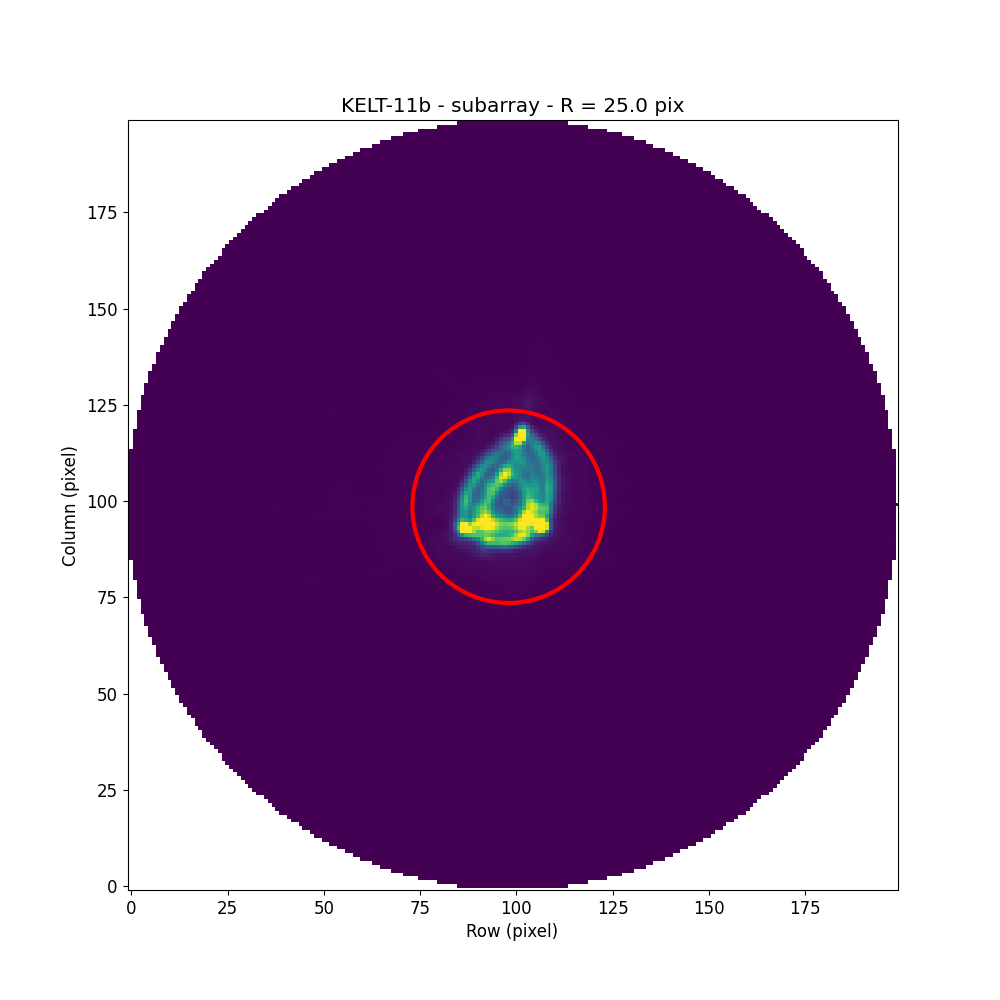

Subarray is saved in the current directory as KELT-11b-subarray-R=25.0pix.gif


In [45]:
#Animation of the data cube
dataset.animate_frames(vmax=0.5)

## Entfernung von Outliern 
(einzelne Datenpunkte, die sehr unterschiedliche Werte zu dem Rest der Daten haben)



In [46]:
#Reject Outliers
time,flux,flux_err = dataset.clip_outliers(verbose=True)


Rejected 7 points more than 5.0 x MAD = 809 ppm from the median


Das hier einfach ausführen. Es ist ein Step der einen Effekt des Instruments korrigiert.

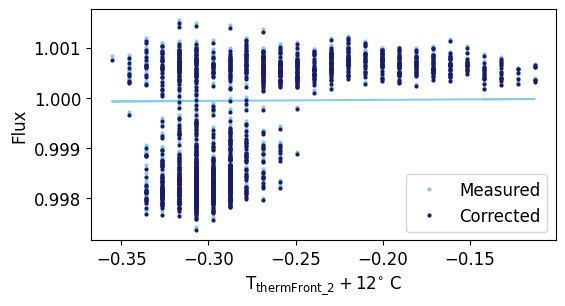

In [47]:
#Correct for ramp
time,flux,flux_err = dataset.correct_ramp(plot=True)

Konvertieren der Transit Eigenschaften in die Einheiten, die wir für die Analyse brauchen. \
Probiert den `cycle` auszuegeben. Was sagt euch dieser Wert?


In [48]:
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt

P = KELT11.P.n        # Orbital period in days
BJD_0 = KELT11.T0.n   # Time of mid-transit as BJD
cycle = np.round((dataset.bjd_ref-BJD_0)/P)
T_0 = BJD_0 - dataset.bjd_ref + cycle*P    # Closest time of mid-transit on same time scale as dataset

D = KELT11.depth.n/1e6  # Depth stored in ppm
W = KELT11.width.n/P    # Width stored in days

f_c = KELT11.f_c
f_s = KELT11.f_s

Jetzt können wir unsere Daten modellieren! Ändert nicht hier!\
Siehst Du einen Transit? 


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 1505
    # variables        = 6
    chi-square         = 2743.58961
    reduced chi-square = 1.83027993
    Akaike info crit   = -20767.3758
    Bayesian info crit = -20735.4765
    RMS residual       = 217.7 ppm
[[Variables]]
    T_0:     0.50159834 +/- 2.2241e-04 (0.04%) (init = 0.5016615)
    P:       4.736204 (fixed)
    D:       0.00208268 +/- 3.2901e-05 (1.58%) (init = 0.001979606)
    W:       0.06137944 +/- 1.4590e-04 (0.24%) (init = 0.06156839)
    b:       0.25305374 +/- 0.09447078 (37.33%) (init = 0.2723883)
    f_c:     0 (fixed)
    f_s:     0 (fixed)
    l_3:     0 (fixed)
    h_1:     0.68961708 +/- 0.00727669 (1.06%) (init = 0.716)
    h_2:     0.444 (fixed)
    c:       1.00064494 +/- 8.1323e-06 (0.00%) (init = 1)
    k:       0.04563640 +/- 3.6046e-04 (0.79%) == 'sqrt(D)'
    aR:      5.26141118 +/- 0.12774316 (2.43%) == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:    0.99

/opt/anaconda3/envs/juliet/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


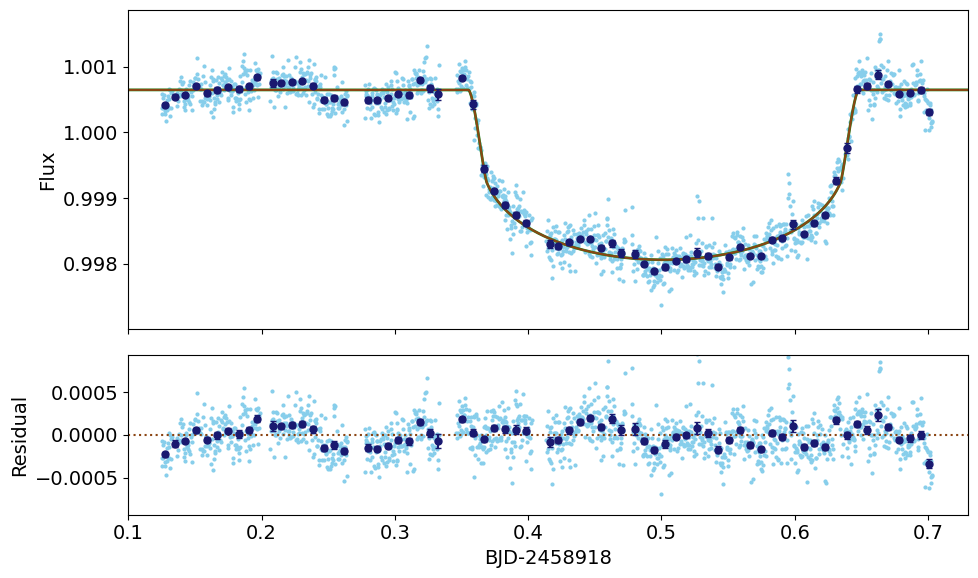

In [49]:
#Initial Fit of the Data
lmfit0 = dataset.lmfit_transit(T_0 = ufloat(T_0, 0.002), P=P,
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=ufloat(0.2723883457, 0.1),
                      f_c=f_c, f_s=f_s,
                      h_1=star.h_1, h_2=star.h_2.n,
                      logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))
fig = dataset.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14)
#Can you see a transit?

Jetzt wählen wir die beste Aperture aus. Dazu nehmen wir die Aperture, bei der der RMS Wert am kleinsten ist.

In [50]:
#Check different apertures
table_of_results = dataset.aperture_scan()

Aperture  Type    R[pxl]  rms[ppm]  mad[ppm] chisq/ndf SNR      N_data
DEFAULT   R25       25.0     217.7     169.8    1.8303    63.31   1505
OPTIMAL   Optimal   28.5     233.6     175.5    2.1145    59.61   1505
RINF       0.9R25   22.5     221.2     172.8    1.8760    61.62   1505
RSUP      1.2R25    30.0     246.2     180.2    2.3485    56.60   1505


/opt/anaconda3/envs/juliet/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/opt/anaconda3/envs/juliet/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/opt/anaconda3/envs/juliet/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/opt/anaconda3/envs/juliet/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Gib dem Namen der besten Aperture hier ein:

In [51]:
aperture = 'DEFAULT' #Enter the best aperture value here
dataset = pycheops.Dataset(file_key)
_ = dataset.get_lightcurve(aperture=aperture,decontaminate=True)
#Reject Outliers
time,flux,flux_err = dataset.clip_outliers(verbose=True)

Found archive tgzfile /Users/yoshi/pycheops/data/CH_PR300024_TG000101_V0200.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 7.83 +- 0.03
Light curve data loaded from  /Users/yoshi/pycheops/data/CH_PR300024_TG000101_V0200-DEFAULT.fits
Time stored relative to BJD = 2458918
Aperture radius used = 25.0 arcsec
UTC start:  2020-03-09T14:50:26
UTC end:    2020-03-10T04:44:49
Visit duration: 50033 s
Exposure time: 2 x 15.0 s
Target location on CCD: (814.4, 280.0)
Number of non-flagged data points: 1512
Efficiency (non-flagged data): 92.0 %
Light curve corrected for flux from background stars
Mean counts = 39037370.8
Median counts = 39052702.8
RMS counts = 56271.9 [1441 ppm]
Median standard error = 6284.8 [161 ppm]
Median background = 276139 e-
Mean contamination = 26.2 ppm
Mean smearing correction = 15.1 ppm
Predicted amplitude of ramp = 49 ppm

Rejected 7 points more than 5.0 x MAD = 809 

Jetzt lassen wir den Fit nochmal laufen:

In [52]:
lmfit0 = dataset.lmfit_transit(T_0 = ufloat(T_0, 0.001), P=P,
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=ufloat(0.2723883457, 0.1),
                      f_c=f_c, f_s=f_s,
                      h_1=star.h_1, h_2=star.h_2.n,
                      logrhoprior=star.logrho)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 1505
    # variables        = 6
    chi-square         = 2751.41153
    reduced chi-square = 1.83549802
    Akaike info crit   = -20759.5539
    Bayesian info crit = -20727.6546
    RMS residual       = 218.1 ppm
[[Variables]]
    T_0:     0.50156847 +/- 2.2161e-04 (0.04%) (init = 0.5016615)
    P:       4.736204 (fixed)
    D:       0.00207232 +/- 3.2939e-05 (1.59%) (init = 0.001979606)
    W:       0.06134791 +/- 1.4659e-04 (0.24%) (init = 0.06156839)
    b:       0.25409280 +/- 0.09457151 (37.22%) (init = 0.2723883)
    f_c:     0 (fixed)
    f_s:     0 (fixed)
    l_3:     0 (fixed)
    h_1:     0.68928573 +/- 0.00731194 (1.06%) (init = 0.716)
    h_2:     0.444 (fixed)
    c:       1.00069365 +/- 8.1414e-06 (0.00%) (init = 1)
    k:       0.04552270 +/- 3.6179e-04 (0.79%) == 'sqrt(D)'
    aR:      5.26215963 +/- 0.12849437 (2.44%) == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:    0.99

/opt/anaconda3/envs/juliet/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Nun suchen wir die besten Basis Vektoren zum Detrenden der Daten. Diese brauchen wir für die weitere Analyse im nächsten Notebook.


In [53]:
#Finding basis vectors for detrending
detrend = dataset.select_detrend(max_bayes_factor=0.5, exclude=['d2fdt2']) #Output that is needed for the juliet fit

Parameter     BF     Delta_BIC RMS(ppm)
+dfdbg          0.00     -77.2    211.8
+dfdcosphi      0.00     -14.6    210.3
+dfdcos2phi     0.04      -6.4    209.5
+dfdcos3phi     0.03      -6.9    208.6
+dfdt           0.32       0.0    208.1


Schreib dir die hier ausgegebenen Parameter auf. Sie werden im nächsten juliet Notebook gebraucht.